# Autoencoders

An autoencoder can be seen as a combination of two networks: the first one encodes the image to a latent space, whereas the second decodes the latent space to produce an image, not necessarily the same.

"According to the history provided in Schmidhuber, "Deep learning in neural networks: an overview," Neural Networks (2015), auto-encoders were proposed as a method for unsupervised pre-training in Ballard, "Modular learning in neural networks," Proceedings AAAI (1987). It's not clear if that's the first time auto-encoders were used, however; it's just the first time that they were used for the purpose of pre-training ANNs." [ref](https://stats.stackexchange.com/questions/238381/what-is-the-origin-of-the-autoencoder-neural-networks)

Autoencoders can use unsupervised learning in the sense that there are no labels in the training set.

![autoencoder](notebook_images/autoencoder.jpg)

### Additional References:

Deconvolution and Checkerboard Artifacts - https://distill.pub/2016/deconv-checkerboard/https://distill.pub/2016/deconv-checkerboard/

Applied Deep Learning - Part3: Autoencoders -https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util


In [2]:
print(torch.__version__)

2.2.1+cu118


In [3]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}

    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, _) in tqdm(enumerate(train_loader, 0)):
            
            inputs = inputs.to(device)
    
            outputs = model(inputs)
    
            loss = loss_fn(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
     
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i,_ in val_loader:
                i = i.to(device)
                o = model(i)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, i).cpu().detach().numpy()


        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Val Loss: {val_loss:0.6f}; Elapsed time: {(stop_time - start_time):0.4f}')

        history['val_loss'].append(val_loss)
        history['loss'].append(epoch_loss)
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'history': history,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')
            best_val_loss = val_loss

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)



class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    
from matplotlib import colors

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


def show_preds(set1, set2, count):
  
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(count, 2 * rows))
  
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')        


## Configuration

In [4]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

MODEL_PATH = 'autoencoder_models'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [5]:
from importlib import reload
reload(vcpi_util)

<module 'vcpi_util' from 'd:\\OnlineFolders\\DropBox\\Dropbox\\VCPI 2324\\DL 07\\../util\\vcpi_util.py'>

## Load and prepare MNIST dataset

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor()]) 

full_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

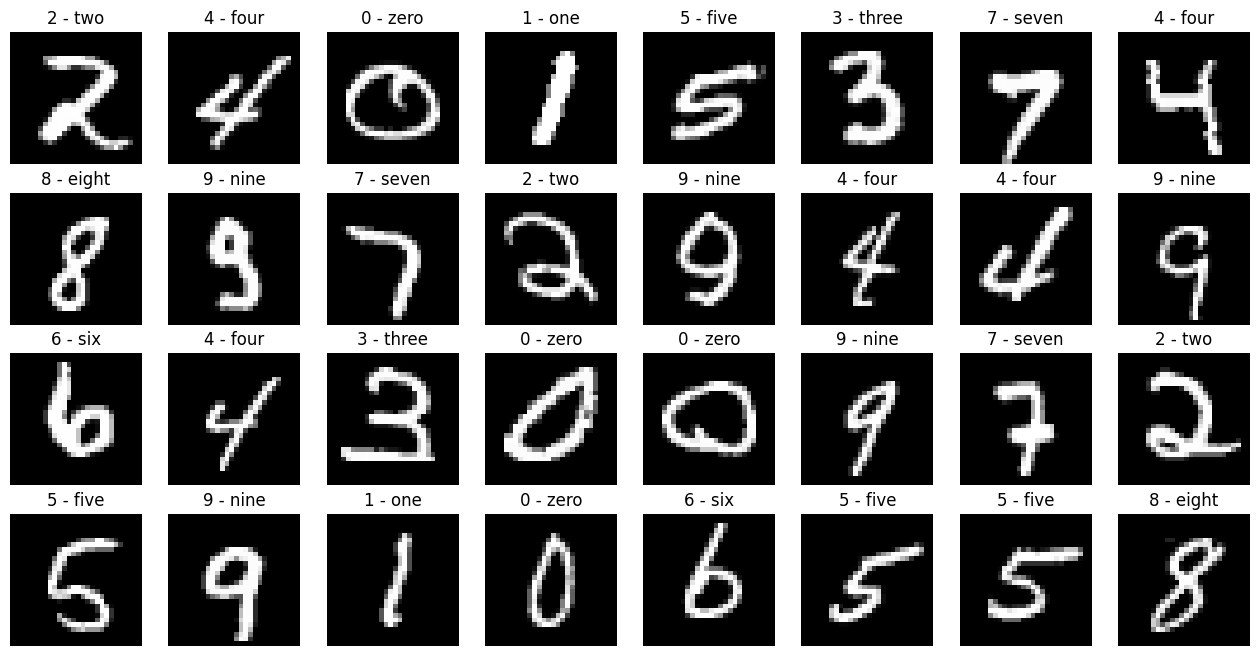

<Figure size 640x480 with 0 Axes>

In [7]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, full_dataset.classes) 

## Autoencoder for reconstruction

![reconstruction](notebook_images/autoencoder_reconstruction.jpg)

In this example we use the autoencoder to learn how to produce an output that matches the input. The autoencoder will be forced to compress the original input in a small latent space, and then decompress it. Since the model has learnt how to decompress the latent space, we can experiment feeding new values in the decoder to get new imagery that should resemble, but not be equal to those in the training set.

### Architecture

In [8]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, latent_space_dim):
        super().__init__()

        # encoder layers
        self.econv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size= 3, stride = 2)
        self.erelu1 = torch.nn.ReLU()
        self.ebn1 = torch.nn.BatchNorm2d(32)

        self.econv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3, stride = 2)
        self.erelu2 = torch.nn.ReLU()
        self.ebn2 = torch.nn.BatchNorm2d(64)

        self.efc1 = torch.nn.Linear(3136, latent_space_dim)

        #decoder layers

        self.dfc1 = torch.nn.Linear(latent_space_dim, 3136)
        
        self.dconvT1 = torch.nn.ConvTranspose2d(64, 32, 3, 2, padding = 1, output_padding=1)
        self.drelu1 = torch.nn.ReLU()
        self.dbn1 = torch.nn.BatchNorm2d(32)

        self.dconvT2 = torch.nn.ConvTranspose2d(32, 1,3,2, padding = 1, output_padding = 1)
        self.dsig = torch.nn.Sigmoid()



    def encoder(self, x):

        
        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv1(x)
        x = self.ebn1(x)
        x = self.erelu1(x)

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv2(x)
        x = self.ebn2(x)
        x = self.erelu2(x)

        x = torch.flatten(x,1)
        x = self.efc1(x)

        return x
        
    def decoder(self,x):

        x = self.dfc1(x)
        x = x.reshape(-1, 64, 7, 7)
        x = self.dconvT1(x)
        x = self.dbn1(x)
        x = self.drelu1(x)

        x = self.dconvT2(x)
        x = self.dsig(x)

        return x



    def forward(self,x):

        encoded = self.encoder(x)
        output = self. decoder(encoded)
        return output    


In [9]:
AE = AutoEncoder(LATENT_SPACE_DIM)
AE.to(device)
print(AE)

torchinfo.summary(AE, input_size=(BATCH_SIZE, 1, 28, 28))

AutoEncoder(
  (econv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (erelu1): ReLU()
  (ebn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (econv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (erelu2): ReLU()
  (ebn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (efc1): Linear(in_features=3136, out_features=2, bias=True)
  (dfc1): Linear(in_features=2, out_features=3136, bias=True)
  (dconvT1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconvT2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dsig): Sigmoid()
)


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 1, 28, 28]           --
├─Conv2d: 1-1                            [32, 32, 14, 14]          320
├─BatchNorm2d: 1-2                       [32, 32, 14, 14]          64
├─ReLU: 1-3                              [32, 32, 14, 14]          --
├─Conv2d: 1-4                            [32, 64, 7, 7]            18,496
├─BatchNorm2d: 1-5                       [32, 64, 7, 7]            128
├─ReLU: 1-6                              [32, 64, 7, 7]            --
├─Linear: 1-7                            [32, 2]                   6,274
├─Linear: 1-8                            [32, 3136]                9,408
├─ConvTranspose2d: 1-9                   [32, 32, 14, 14]          18,464
├─BatchNorm2d: 1-10                      [32, 32, 14, 14]          64
├─ReLU: 1-11                             [32, 32, 14, 14]          --
├─ConvTranspose2d: 1-12                  [32, 1, 28, 28]           28

### Prepare and train model

In [78]:
latent_dims = [2,4,8,16]

loss_fn = torch.nn.loss_fn = torch.nn.MSELoss()

for ld in latent_dims:
    
    AE = AutoEncoder(ld)
    AE.to(device)

    opt = torch.optim.Adam(AE.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor = 0.1, patience=3)
    early_stop = Early_Stopping(9)
    
    history=train(AE, train_loader, val_loader, 100, loss_fn, opt,  scheduler, early_stop, f'{MODEL_PATH}/autoencoder_{ld}' )

1500it [00:11, 129.66it/s]


Epoch: 000; Loss: 0.001854; Val Loss: 0.001538; Elapsed time: 13.2012


1500it [00:10, 137.41it/s]


Epoch: 001; Loss: 0.001504; Val Loss: 0.001486; Elapsed time: 12.5870


1500it [00:10, 139.34it/s]


Epoch: 002; Loss: 0.001459; Val Loss: 0.001447; Elapsed time: 12.4065


1500it [00:11, 134.71it/s]


Epoch: 003; Loss: 0.001429; Val Loss: 0.001419; Elapsed time: 12.8776


1500it [00:11, 135.71it/s]


Epoch: 004; Loss: 0.001409; Val Loss: 0.001414; Elapsed time: 12.7846


1500it [00:10, 137.05it/s]


Epoch: 005; Loss: 0.001392; Val Loss: 0.001392; Elapsed time: 12.6659


1500it [00:10, 136.38it/s]


Epoch: 006; Loss: 0.001379; Val Loss: 0.001380; Elapsed time: 12.7525


1500it [00:11, 136.35it/s]


Epoch: 007; Loss: 0.001368; Val Loss: 0.001373; Elapsed time: 12.7015


1500it [00:11, 136.11it/s]


Epoch: 008; Loss: 0.001359; Val Loss: 0.001363; Elapsed time: 12.6806


1500it [00:10, 136.51it/s]


Epoch: 009; Loss: 0.001352; Val Loss: 0.001360; Elapsed time: 12.6806


1500it [00:11, 136.02it/s]


Epoch: 010; Loss: 0.001346; Val Loss: 0.001358; Elapsed time: 12.7360


1500it [00:10, 136.99it/s]


Epoch: 011; Loss: 0.001341; Val Loss: 0.001353; Elapsed time: 12.5891


1500it [00:10, 137.04it/s]


Epoch: 012; Loss: 0.001335; Val Loss: 0.001348; Elapsed time: 12.8237


1500it [00:10, 136.42it/s]


Epoch: 013; Loss: 0.001332; Val Loss: 0.001339; Elapsed time: 12.6814


1500it [00:10, 138.43it/s]


Epoch: 014; Loss: 0.001329; Val Loss: 0.001338; Elapsed time: 12.5609


1500it [00:11, 132.59it/s]


Epoch: 015; Loss: 0.001324; Val Loss: 0.001336; Elapsed time: 13.2665


1500it [00:11, 125.70it/s]


Epoch: 016; Loss: 0.001322; Val Loss: 0.001335; Elapsed time: 13.8246


1500it [00:11, 129.56it/s]


Epoch: 017; Loss: 0.001318; Val Loss: 0.001333; Elapsed time: 13.4199


1500it [00:10, 136.83it/s]


Epoch: 018; Loss: 0.001316; Val Loss: 0.001330; Elapsed time: 12.5954


1500it [00:10, 136.91it/s]


Epoch: 019; Loss: 0.001313; Val Loss: 0.001328; Elapsed time: 12.6129


1500it [00:10, 139.72it/s]


Epoch: 020; Loss: 0.001310; Val Loss: 0.001331; Elapsed time: 12.5333


1500it [00:10, 138.11it/s]


Epoch: 021; Loss: 0.001309; Val Loss: 0.001334; Elapsed time: 12.5117


1500it [00:10, 138.70it/s]


Epoch: 022; Loss: 0.001307; Val Loss: 0.001325; Elapsed time: 12.5685


1500it [00:11, 131.73it/s]


Epoch: 023; Loss: 0.001305; Val Loss: 0.001328; Elapsed time: 13.0579


1500it [00:10, 138.46it/s]


Epoch: 024; Loss: 0.001303; Val Loss: 0.001326; Elapsed time: 12.6043


1500it [00:11, 133.56it/s]


Epoch: 025; Loss: 0.001301; Val Loss: 0.001326; Elapsed time: 13.0367


1500it [00:11, 135.30it/s]


Epoch: 026; Loss: 0.001299; Val Loss: 0.001323; Elapsed time: 12.7473


1500it [00:11, 134.40it/s]


Epoch: 027; Loss: 0.001298; Val Loss: 0.001323; Elapsed time: 12.8236


1500it [00:10, 136.64it/s]


Epoch: 028; Loss: 0.001297; Val Loss: 0.001320; Elapsed time: 12.6893


1500it [00:11, 136.04it/s]


Epoch: 029; Loss: 0.001295; Val Loss: 0.001320; Elapsed time: 12.7054
Early stopping!
Finished Training


1500it [00:11, 134.78it/s]


Epoch: 000; Loss: 0.001435; Val Loss: 0.001185; Elapsed time: 12.8366


1500it [00:10, 136.94it/s]


Epoch: 001; Loss: 0.001140; Val Loss: 0.001094; Elapsed time: 12.7231


1500it [00:11, 135.22it/s]


Epoch: 002; Loss: 0.001072; Val Loss: 0.001052; Elapsed time: 12.7998


1500it [00:11, 134.36it/s]


Epoch: 003; Loss: 0.001038; Val Loss: 0.001028; Elapsed time: 12.8913


1500it [00:10, 136.47it/s]


Epoch: 004; Loss: 0.001017; Val Loss: 0.001009; Elapsed time: 12.6810


1500it [00:10, 138.62it/s]


Epoch: 005; Loss: 0.001001; Val Loss: 0.001003; Elapsed time: 12.4565


1500it [00:10, 139.87it/s]


Epoch: 006; Loss: 0.000990; Val Loss: 0.000994; Elapsed time: 12.3293


1500it [00:10, 136.78it/s]


Epoch: 007; Loss: 0.000981; Val Loss: 0.000984; Elapsed time: 12.6327


1500it [00:10, 138.26it/s]


Epoch: 008; Loss: 0.000973; Val Loss: 0.000978; Elapsed time: 12.5844


1500it [00:11, 135.25it/s]


Epoch: 009; Loss: 0.000967; Val Loss: 0.000977; Elapsed time: 12.9024


1500it [00:10, 139.57it/s]


Epoch: 010; Loss: 0.000962; Val Loss: 0.000968; Elapsed time: 12.5648


1500it [00:10, 136.53it/s]


Epoch: 011; Loss: 0.000956; Val Loss: 0.000971; Elapsed time: 12.7497


1500it [00:11, 134.55it/s]


Epoch: 012; Loss: 0.000953; Val Loss: 0.000965; Elapsed time: 12.8440


1500it [00:11, 136.00it/s]


Epoch: 013; Loss: 0.000949; Val Loss: 0.000959; Elapsed time: 12.7558


1500it [00:11, 136.04it/s]


Epoch: 014; Loss: 0.000945; Val Loss: 0.000961; Elapsed time: 12.6669


1500it [00:11, 135.66it/s]


Epoch: 015; Loss: 0.000942; Val Loss: 0.000961; Elapsed time: 12.7489


1500it [00:11, 134.02it/s]


Epoch: 016; Loss: 0.000940; Val Loss: 0.000957; Elapsed time: 12.8781


1500it [00:11, 132.22it/s]


Epoch: 017; Loss: 0.000937; Val Loss: 0.000951; Elapsed time: 13.1452


1500it [00:11, 133.98it/s]


Epoch: 018; Loss: 0.000935; Val Loss: 0.000948; Elapsed time: 13.0178


1500it [00:11, 135.51it/s]


Epoch: 019; Loss: 0.000933; Val Loss: 0.000949; Elapsed time: 12.7485


1500it [00:10, 136.80it/s]


Epoch: 020; Loss: 0.000931; Val Loss: 0.000951; Elapsed time: 12.6718


1500it [00:11, 132.60it/s]


Epoch: 021; Loss: 0.000928; Val Loss: 0.000949; Elapsed time: 13.0736


1500it [00:11, 133.43it/s]


Epoch: 022; Loss: 0.000927; Val Loss: 0.000944; Elapsed time: 13.0775


1500it [00:11, 134.85it/s]


Epoch: 023; Loss: 0.000925; Val Loss: 0.000943; Elapsed time: 12.8516


1500it [00:11, 132.96it/s]


Epoch: 024; Loss: 0.000923; Val Loss: 0.000943; Elapsed time: 13.0762


1500it [00:11, 136.27it/s]


Epoch: 025; Loss: 0.000922; Val Loss: 0.000942; Elapsed time: 12.8398


1500it [00:11, 134.11it/s]


Epoch: 026; Loss: 0.000920; Val Loss: 0.000943; Elapsed time: 12.9073


1500it [00:11, 134.78it/s]


Epoch: 027; Loss: 0.000919; Val Loss: 0.000939; Elapsed time: 12.9009


1500it [00:11, 135.85it/s]


Epoch: 028; Loss: 0.000918; Val Loss: 0.000937; Elapsed time: 12.7034


1500it [00:11, 132.42it/s]


Epoch: 029; Loss: 0.000917; Val Loss: 0.000939; Elapsed time: 13.1279


1500it [00:11, 134.26it/s]


Epoch: 030; Loss: 0.000915; Val Loss: 0.000938; Elapsed time: 12.8606


1500it [00:11, 133.65it/s]


Epoch: 031; Loss: 0.000915; Val Loss: 0.000936; Elapsed time: 12.9309


1500it [00:11, 132.89it/s]


Epoch: 032; Loss: 0.000914; Val Loss: 0.000936; Elapsed time: 12.9493
Early stopping!
Finished Training


1500it [00:11, 135.93it/s]


Epoch: 000; Loss: 0.000992; Val Loss: 0.000749; Elapsed time: 12.7682


1500it [00:11, 132.08it/s]


Epoch: 001; Loss: 0.000714; Val Loss: 0.000686; Elapsed time: 13.0696


1500it [00:11, 134.88it/s]


Epoch: 002; Loss: 0.000669; Val Loss: 0.000660; Elapsed time: 12.8151


1500it [00:11, 134.95it/s]


Epoch: 003; Loss: 0.000642; Val Loss: 0.000627; Elapsed time: 12.8782


1500it [00:11, 135.05it/s]


Epoch: 004; Loss: 0.000624; Val Loss: 0.000618; Elapsed time: 12.9203


1500it [00:11, 134.88it/s]


Epoch: 005; Loss: 0.000609; Val Loss: 0.000606; Elapsed time: 12.9329


1500it [00:11, 133.90it/s]


Epoch: 006; Loss: 0.000599; Val Loss: 0.000594; Elapsed time: 12.9725


1500it [00:10, 139.57it/s]


Epoch: 007; Loss: 0.000589; Val Loss: 0.000587; Elapsed time: 12.3764


1500it [00:11, 133.07it/s]


Epoch: 008; Loss: 0.000582; Val Loss: 0.000591; Elapsed time: 13.0402


1500it [00:11, 130.46it/s]


Epoch: 009; Loss: 0.000576; Val Loss: 0.000584; Elapsed time: 13.2177


1500it [00:11, 131.62it/s]


Epoch: 010; Loss: 0.000570; Val Loss: 0.000571; Elapsed time: 13.1610


1500it [00:10, 137.33it/s]


Epoch: 011; Loss: 0.000565; Val Loss: 0.000567; Elapsed time: 12.6304


1500it [00:11, 135.22it/s]


Epoch: 012; Loss: 0.000560; Val Loss: 0.000577; Elapsed time: 12.7122


1500it [00:11, 135.44it/s]


Epoch: 013; Loss: 0.000557; Val Loss: 0.000564; Elapsed time: 12.8555


1500it [00:11, 133.44it/s]


Epoch: 014; Loss: 0.000553; Val Loss: 0.000558; Elapsed time: 12.9659


1500it [00:11, 135.70it/s]


Epoch: 015; Loss: 0.000549; Val Loss: 0.000554; Elapsed time: 12.8188


1500it [00:11, 131.14it/s]


Epoch: 016; Loss: 0.000547; Val Loss: 0.000563; Elapsed time: 13.3663


1500it [00:11, 134.11it/s]


Epoch: 017; Loss: 0.000544; Val Loss: 0.000553; Elapsed time: 12.8806


1500it [00:11, 131.22it/s]


Epoch: 018; Loss: 0.000542; Val Loss: 0.000550; Elapsed time: 13.2216


1500it [00:11, 135.48it/s]


Epoch: 019; Loss: 0.000539; Val Loss: 0.000546; Elapsed time: 12.7678


1500it [00:10, 137.84it/s]


Epoch: 020; Loss: 0.000537; Val Loss: 0.000553; Elapsed time: 12.5503


1500it [00:11, 134.66it/s]


Epoch: 021; Loss: 0.000535; Val Loss: 0.000546; Elapsed time: 12.7931


1500it [00:10, 140.13it/s]


Epoch: 022; Loss: 0.000533; Val Loss: 0.000541; Elapsed time: 12.4398


1500it [00:11, 133.44it/s]


Epoch: 023; Loss: 0.000531; Val Loss: 0.000542; Elapsed time: 13.0009


1500it [00:11, 129.76it/s]


Epoch: 024; Loss: 0.000529; Val Loss: 0.000541; Elapsed time: 13.2578


1500it [00:11, 134.35it/s]


Epoch: 025; Loss: 0.000528; Val Loss: 0.000541; Elapsed time: 12.9618


1500it [00:11, 133.60it/s]


Epoch: 026; Loss: 0.000526; Val Loss: 0.000542; Elapsed time: 12.9178


1500it [00:11, 133.45it/s]


Epoch: 027; Loss: 0.000525; Val Loss: 0.000536; Elapsed time: 12.8642


1500it [00:11, 131.66it/s]


Epoch: 028; Loss: 0.000524; Val Loss: 0.000536; Elapsed time: 13.3167


1500it [00:12, 120.29it/s]


Epoch: 029; Loss: 0.000522; Val Loss: 0.000534; Elapsed time: 14.3924


1500it [00:11, 128.94it/s]


Epoch: 030; Loss: 0.000521; Val Loss: 0.000532; Elapsed time: 13.3726


1500it [00:11, 132.87it/s]


Epoch: 031; Loss: 0.000520; Val Loss: 0.000534; Elapsed time: 12.9467


1500it [00:12, 123.00it/s]


Epoch: 032; Loss: 0.000518; Val Loss: 0.000532; Elapsed time: 14.2892


1500it [00:12, 122.86it/s]


Epoch: 033; Loss: 0.000518; Val Loss: 0.000531; Elapsed time: 13.8800


1500it [00:11, 130.67it/s]


Epoch: 034; Loss: 0.000516; Val Loss: 0.000529; Elapsed time: 13.2210


1500it [00:11, 131.12it/s]


Epoch: 035; Loss: 0.000515; Val Loss: 0.000532; Elapsed time: 13.1963


1500it [00:12, 124.06it/s]


Epoch: 036; Loss: 0.000514; Val Loss: 0.000529; Elapsed time: 13.9880


1500it [00:12, 123.82it/s]


Epoch: 037; Loss: 0.000514; Val Loss: 0.000535; Elapsed time: 14.1212
Early stopping!
Finished Training


1500it [00:12, 119.21it/s]


Epoch: 000; Loss: 0.000868; Val Loss: 0.000441; Elapsed time: 14.7565


1500it [00:12, 116.93it/s]


Epoch: 001; Loss: 0.000401; Val Loss: 0.000373; Elapsed time: 14.6165


1500it [00:11, 129.32it/s]


Epoch: 002; Loss: 0.000354; Val Loss: 0.000338; Elapsed time: 13.5384


1500it [00:12, 124.87it/s]


Epoch: 003; Loss: 0.000330; Val Loss: 0.000321; Elapsed time: 14.0912


1500it [00:11, 128.99it/s]


Epoch: 004; Loss: 0.000313; Val Loss: 0.000311; Elapsed time: 13.3638


1500it [00:11, 129.49it/s]


Epoch: 005; Loss: 0.000302; Val Loss: 0.000304; Elapsed time: 13.2984


1500it [00:11, 132.51it/s]


Epoch: 006; Loss: 0.000294; Val Loss: 0.000292; Elapsed time: 13.1961


1500it [00:11, 131.44it/s]


Epoch: 007; Loss: 0.000287; Val Loss: 0.000286; Elapsed time: 13.3229


1500it [00:11, 129.69it/s]


Epoch: 008; Loss: 0.000282; Val Loss: 0.000288; Elapsed time: 13.3818


1500it [00:11, 131.22it/s]


Epoch: 009; Loss: 0.000277; Val Loss: 0.000278; Elapsed time: 13.1668


1500it [00:11, 132.88it/s]


Epoch: 010; Loss: 0.000273; Val Loss: 0.000282; Elapsed time: 13.0398


1500it [00:11, 134.43it/s]


Epoch: 011; Loss: 0.000270; Val Loss: 0.000273; Elapsed time: 12.8388


1500it [00:11, 134.13it/s]


Epoch: 012; Loss: 0.000267; Val Loss: 0.000270; Elapsed time: 12.8472


1500it [00:11, 135.58it/s]


Epoch: 013; Loss: 0.000265; Val Loss: 0.000269; Elapsed time: 12.8394


1500it [00:11, 131.24it/s]


Epoch: 014; Loss: 0.000262; Val Loss: 0.000267; Elapsed time: 13.3210


1500it [00:11, 133.76it/s]


Epoch: 015; Loss: 0.000260; Val Loss: 0.000269; Elapsed time: 12.8884


1500it [00:11, 132.30it/s]


Epoch: 016; Loss: 0.000259; Val Loss: 0.000265; Elapsed time: 13.1698


1500it [00:11, 130.14it/s]


Epoch: 017; Loss: 0.000256; Val Loss: 0.000263; Elapsed time: 13.1870


1500it [00:11, 134.74it/s]


Epoch: 018; Loss: 0.000255; Val Loss: 0.000261; Elapsed time: 12.8829


1500it [00:11, 135.43it/s]


Epoch: 019; Loss: 0.000253; Val Loss: 0.000263; Elapsed time: 12.8177


1500it [00:11, 131.62it/s]


Epoch: 020; Loss: 0.000252; Val Loss: 0.000261; Elapsed time: 13.0984


1500it [00:11, 132.88it/s]


Epoch: 021; Loss: 0.000251; Val Loss: 0.000260; Elapsed time: 13.0630


1500it [00:11, 129.36it/s]


Epoch: 022; Loss: 0.000249; Val Loss: 0.000262; Elapsed time: 13.3108


1500it [00:11, 128.15it/s]


Epoch: 023; Loss: 0.000248; Val Loss: 0.000256; Elapsed time: 13.5386


1500it [00:11, 136.28it/s]


Epoch: 024; Loss: 0.000247; Val Loss: 0.000258; Elapsed time: 12.7548


1500it [00:11, 131.95it/s]


Epoch: 025; Loss: 0.000246; Val Loss: 0.000255; Elapsed time: 13.1559


1500it [00:11, 134.70it/s]


Epoch: 026; Loss: 0.000245; Val Loss: 0.000257; Elapsed time: 12.8200


1500it [00:10, 137.66it/s]


Epoch: 027; Loss: 0.000244; Val Loss: 0.000255; Elapsed time: 12.5350


1500it [00:11, 129.45it/s]


Epoch: 028; Loss: 0.000243; Val Loss: 0.000252; Elapsed time: 13.4660


1500it [00:11, 130.85it/s]


Epoch: 029; Loss: 0.000242; Val Loss: 0.000252; Elapsed time: 13.1844


1500it [00:10, 136.62it/s]


Epoch: 030; Loss: 0.000242; Val Loss: 0.000256; Elapsed time: 12.7959


1500it [00:11, 133.81it/s]


Epoch: 031; Loss: 0.000241; Val Loss: 0.000254; Elapsed time: 12.9279


1500it [00:11, 135.02it/s]


==> Learning rate updated:  0.001  ->  0.0001
Epoch: 032; Loss: 0.000240; Val Loss: 0.000253; Elapsed time: 12.7670


1500it [00:11, 134.68it/s]


Epoch: 033; Loss: 0.000227; Val Loss: 0.000240; Elapsed time: 12.8468


1500it [00:11, 130.29it/s]


Epoch: 034; Loss: 0.000226; Val Loss: 0.000240; Elapsed time: 13.3489


1500it [00:11, 135.22it/s]


Epoch: 035; Loss: 0.000225; Val Loss: 0.000240; Elapsed time: 12.8151


1500it [00:11, 132.65it/s]


Epoch: 036; Loss: 0.000225; Val Loss: 0.000240; Elapsed time: 13.0597


1500it [00:11, 135.67it/s]


Epoch: 037; Loss: 0.000224; Val Loss: 0.000240; Elapsed time: 12.7648


1500it [00:11, 134.36it/s]


Epoch: 038; Loss: 0.000224; Val Loss: 0.000240; Elapsed time: 12.9085


1500it [00:11, 133.37it/s]


Epoch: 039; Loss: 0.000224; Val Loss: 0.000240; Elapsed time: 13.1356


1500it [00:11, 127.02it/s]


Epoch: 040; Loss: 0.000224; Val Loss: 0.000239; Elapsed time: 13.4797


1500it [00:11, 132.77it/s]


Epoch: 041; Loss: 0.000224; Val Loss: 0.000239; Elapsed time: 13.1892


1500it [00:11, 134.13it/s]


Epoch: 042; Loss: 0.000224; Val Loss: 0.000239; Elapsed time: 12.8838


1500it [00:11, 135.38it/s]


Epoch: 043; Loss: 0.000223; Val Loss: 0.000239; Elapsed time: 12.7221
Early stopping!
Finished Training


#### Plotting the losses for the trained models

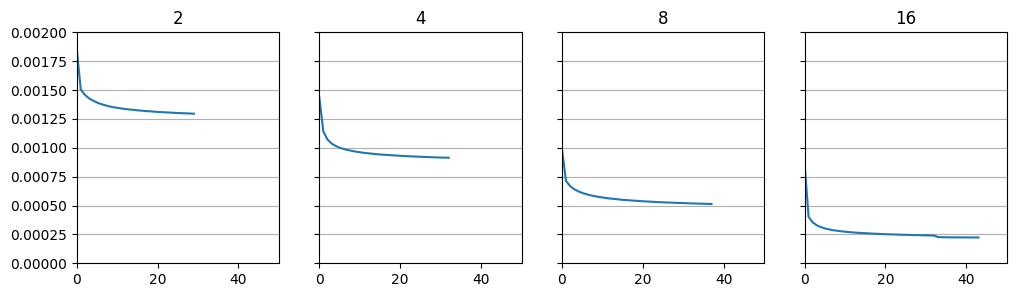

<Figure size 640x480 with 0 Axes>

In [10]:
latent_dims = [2,4,8,16]

f, axes= plt.subplots(1,4, figsize=(12,3))
fig=plt.figure()  

for index, i in enumerate(latent_dims):
    reload = torch.load(f'autoencoder_models/autoencoder_{i}_best.pt')
    history = reload['history']
    axes[index].plot(history['loss'])
    axes[index].set_ylim(0, 0.002)
    axes[index].set_xlim(0, 50)
    axes[index].set_title(f'{i}')
    axes[index].grid(axis = 'y')
    if index > 0:
        axes[index].set_yticklabels([])

    
plt.show()

In [11]:
LATENT_SPACE_DIM = 2
reload = torch.load(f'autoencoder_models/autoencoder_{LATENT_SPACE_DIM}_best.pt')
print(reload['epoch'])
AE = AutoEncoder(LATENT_SPACE_DIM)
AE.to(device)
AE.load_state_dict(reload['model'])



29


<All keys matched successfully>

### Apply model to the test set and visualize some results

A latent space with only two elements is clearly not sufficient to rebuilt the inputs. However, using two elements only allows us to create some meaningful plots that help to illustrate the full potential of the autoencoder.

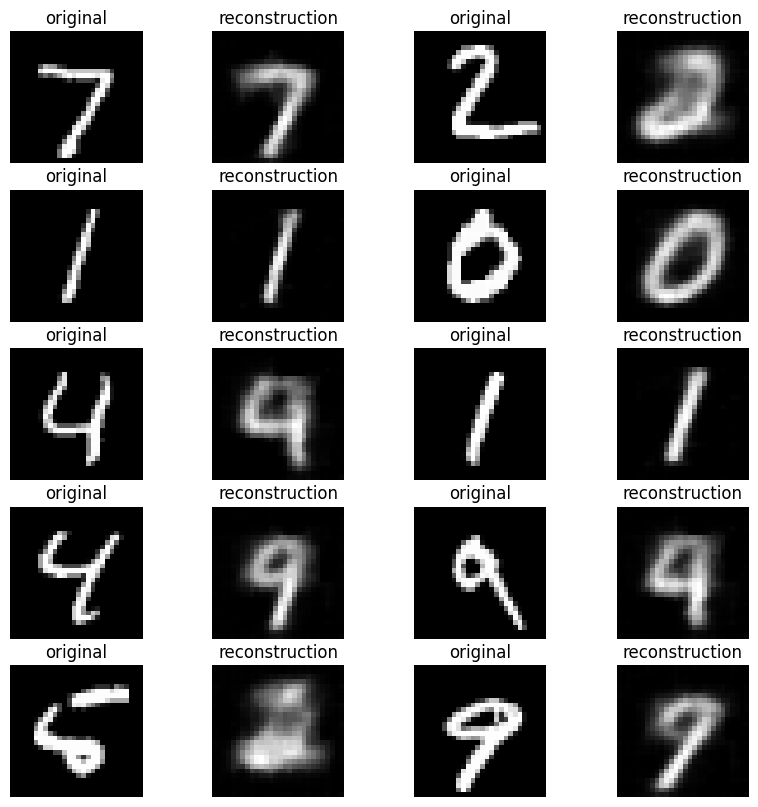

In [12]:
i, _ = next(iter(test_loader))
recon = AE(i.to(device))
    
show_preds(i, recon, 10)

### Plotting the latent space with class color coding

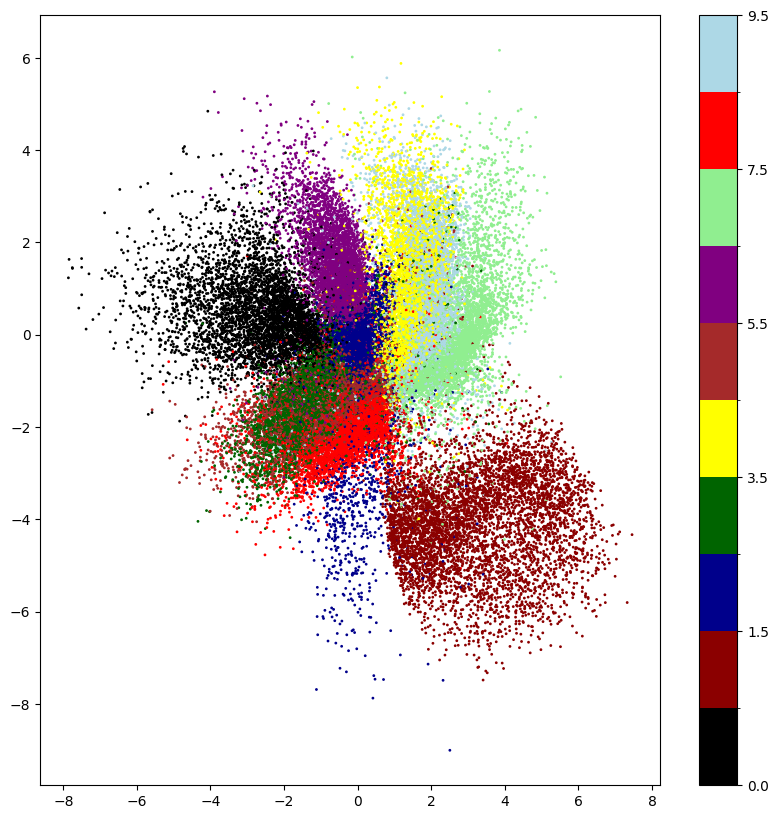

In [13]:


if LATENT_SPACE_DIM == 2:

    encoded = []
    targets = []
    for i,t in train_loader:
        encoded.extend(AE.encoder(i.to(device)).cpu().detach().numpy())
        targets.extend(t)

    x = np.array(encoded)[:,0]
    y = np.array(encoded)[:,1]

    plot_scatter(x,y,targets)


Show a reconstruction from a new latent space 

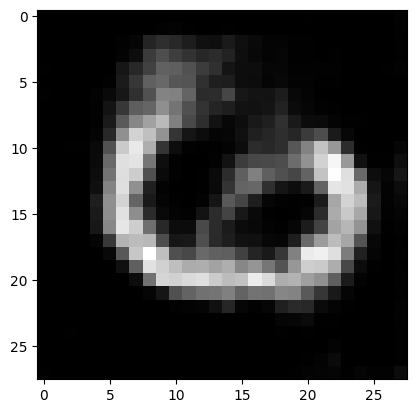

In [14]:
if LATENT_SPACE_DIM == 2:
    pred = AE.decoder(torch.Tensor([[-3,4]]).to(device))
    plt.imshow(np.transpose(pred[0].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)

### Exploring the latent space

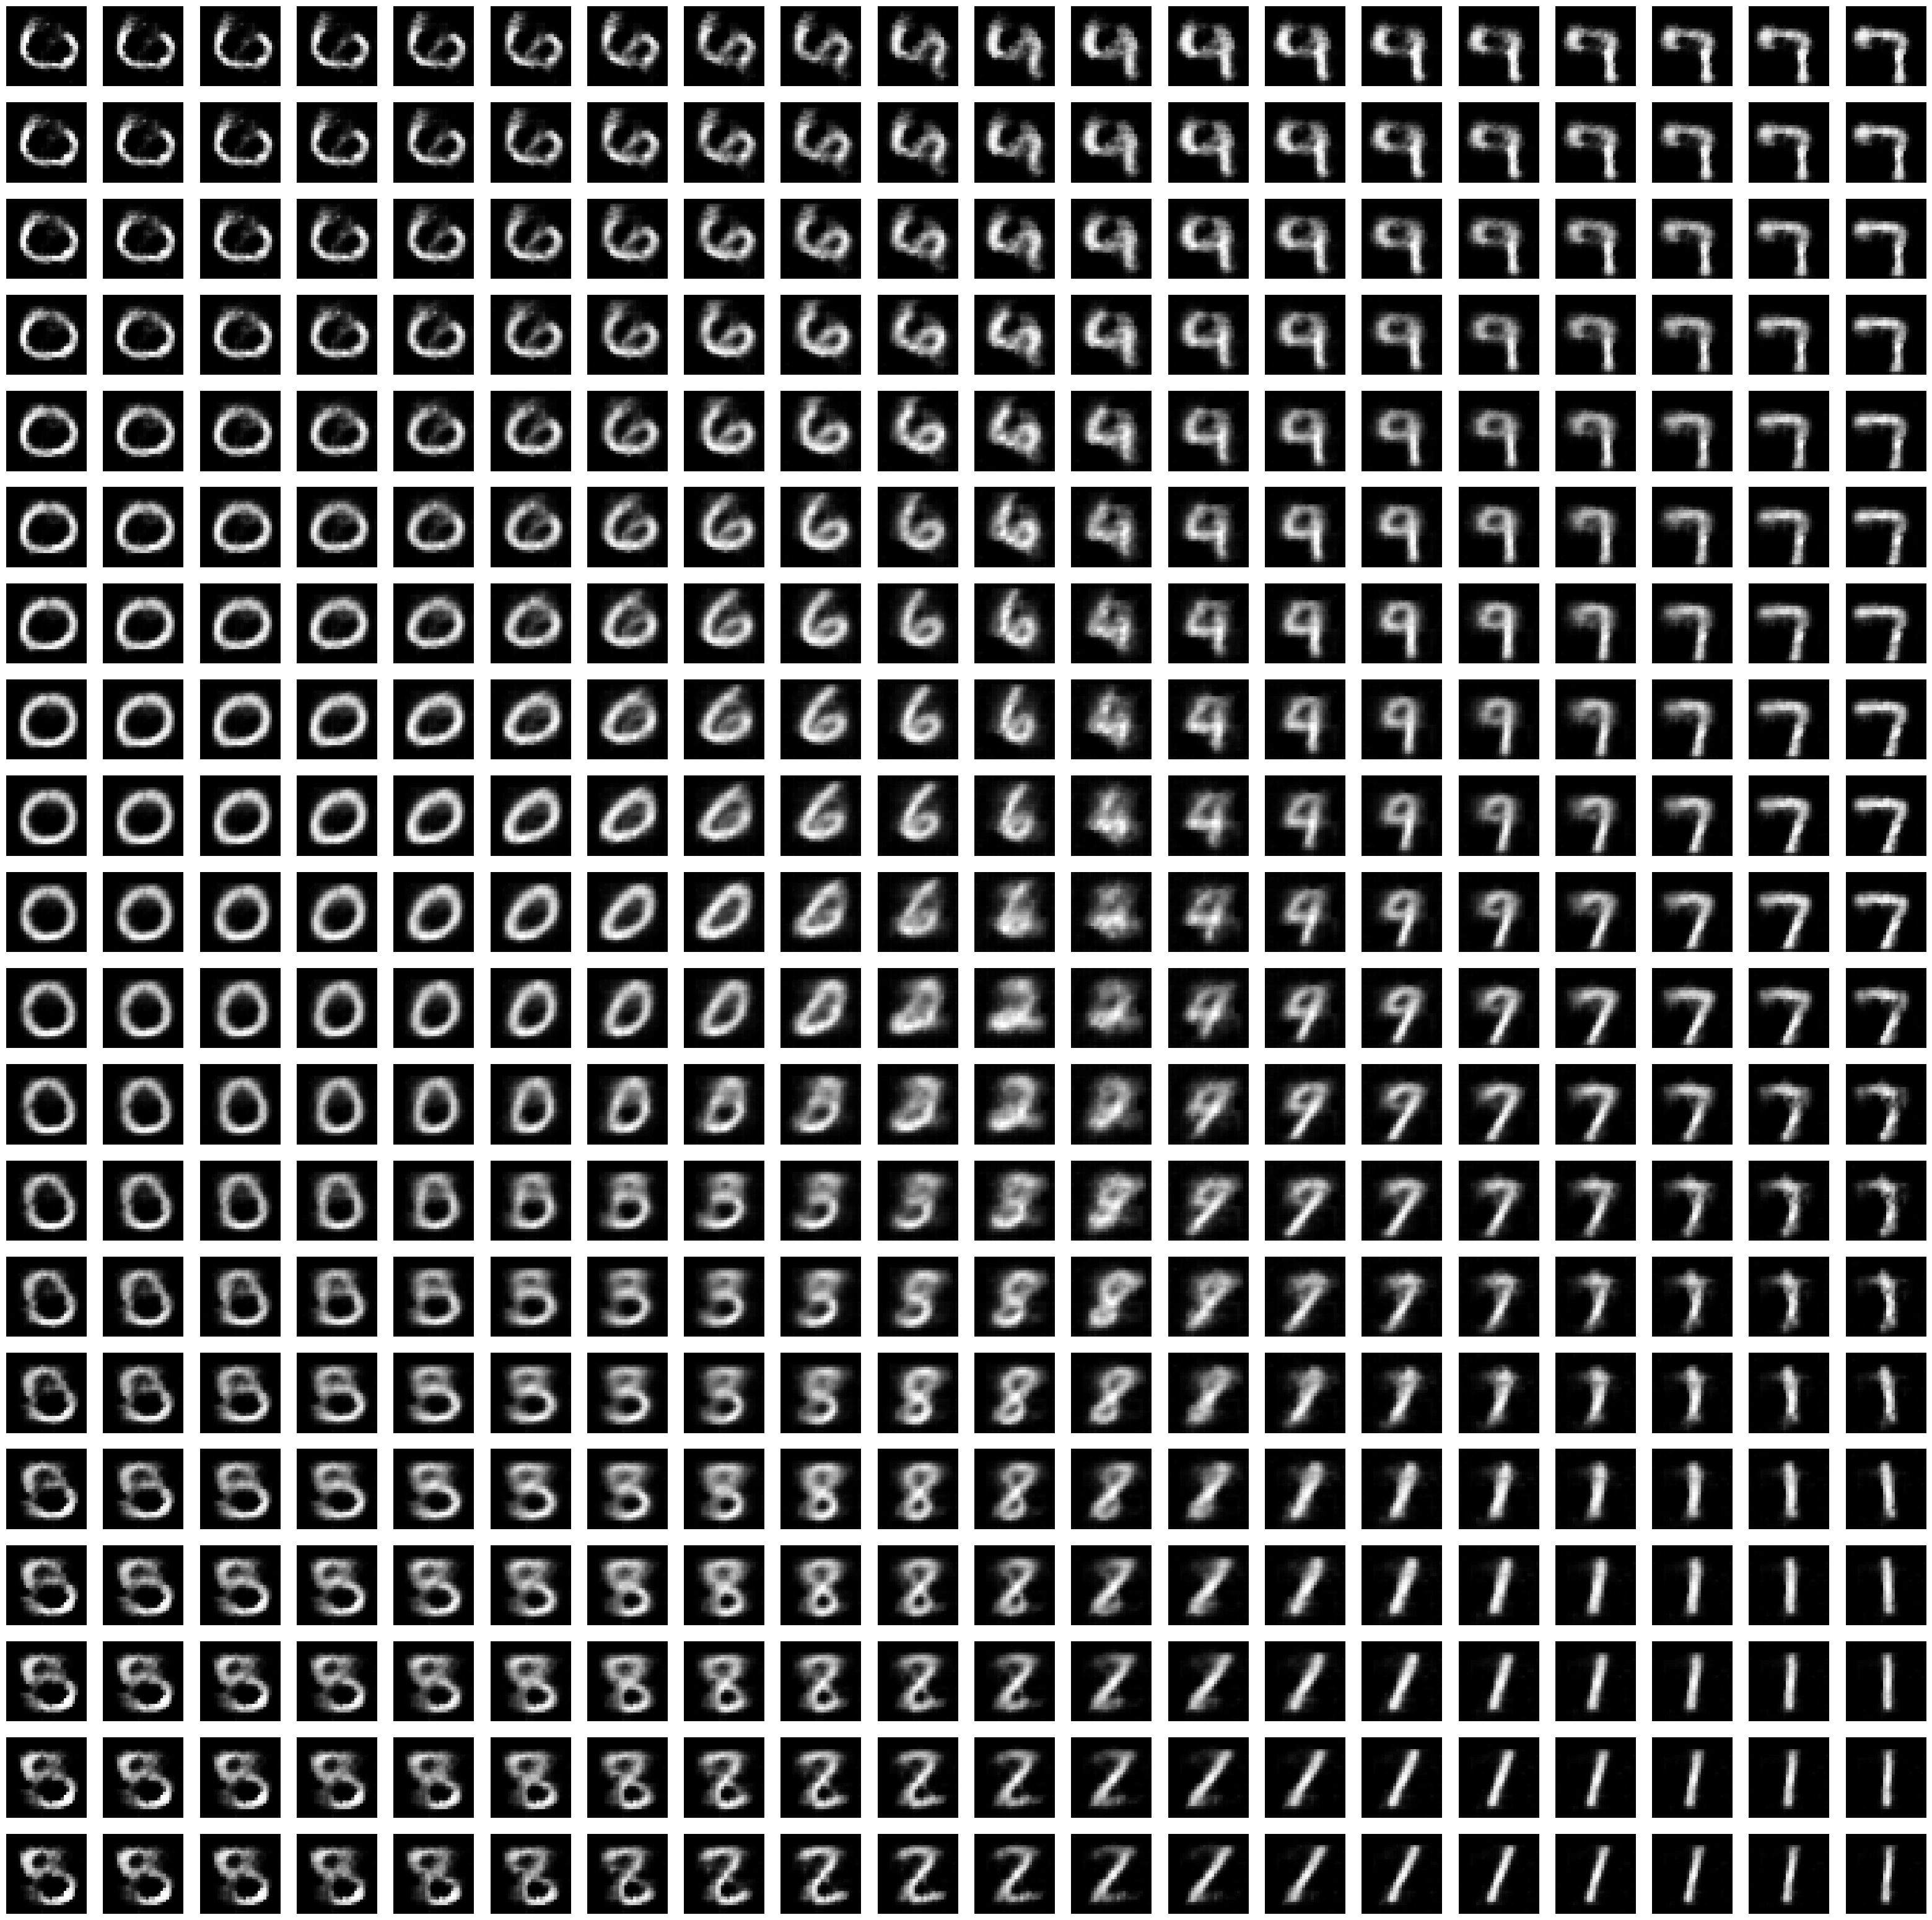

<Figure size 640x480 with 0 Axes>

In [15]:
if LATENT_SPACE_DIM == 2:
    limit = 5
    steps = 20

    step = (2.0 * limit) / steps

    vector_generation = [[-limit + j*step, limit - i*step] 
                                for i in range(steps) for j in range(steps)]

    predictions = AE.decoder(torch.Tensor(vector_generation).to(device))

    vcpi_util.show_predicted_images(steps, steps, predictions.cpu().detach(), 10)


### Results with different latent space dimensions

![varying latent space dimension](notebook_images/varying_latent_space.png)

As can be seen with larger latent spaces we are starting to get very decent results.

## Anomaly Detection

Check if an image is consistent with the training set

![anomaly detection test](notebook_images/anomaly_detection.jpg)

Image is fed in the autoencoder, and the reconstruction is retrieved. It is expected that for images not consistent with the training set that a larger reconstruction error is obtained

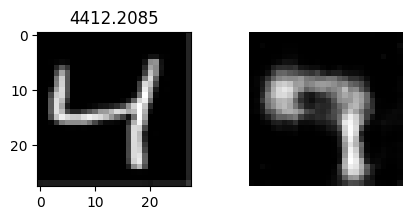

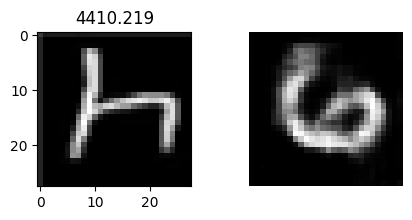

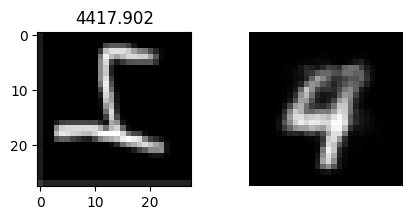

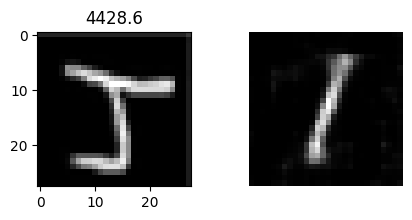

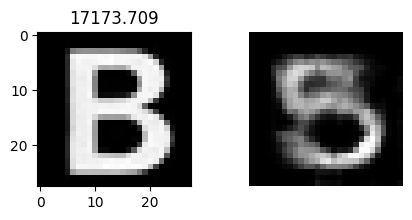

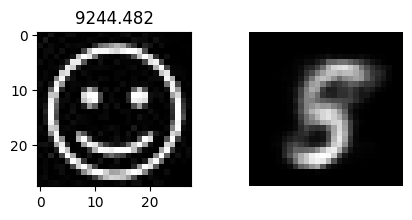

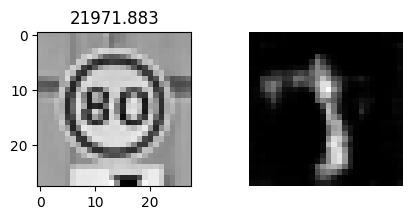

In [25]:
import glob

def show_anomaly_sample(image, recon, err):
        plt.figure(figsize=(5,2))
        ax = plt.subplot(1,2,1)
        plt.imshow(image, cmap='gray')
        plt.title(str(err))
        ax = plt.subplot(1,2,2)
        plt.imshow(recon, cmap='gray')
        plt.axis('off')

def anomalyDetection(image_path):

    files = glob.glob(f'{image_path}/*.jpg')
    for f in files:
        
        img = Image.open(f).convert('L').resize((28,28))
        data = transform(img).to(device).view(1,1,28,28)
        testing = AE(data)
        err = np.mean((img - testing.cpu().detach().numpy()) ** 2)

        show_anomaly_sample(img, np.transpose(testing[0].cpu().detach().numpy(),(1,2,0)), err)


image_path = 'anomalyDetectionImages'
anomalyDetection(image_path)

## Image Based Content Retrieval

In [28]:
# get latent space for training set
features = []

for i in range(train_set.__len__()):
    features.extend(AE.encoder(train_set[i][0].view(1,1,28,28).to(device)))

# build a dict from index to features from latent_space
indexes = list(range(0, train_set.__len__()))
data = {"indexes": indexes, "features": features}

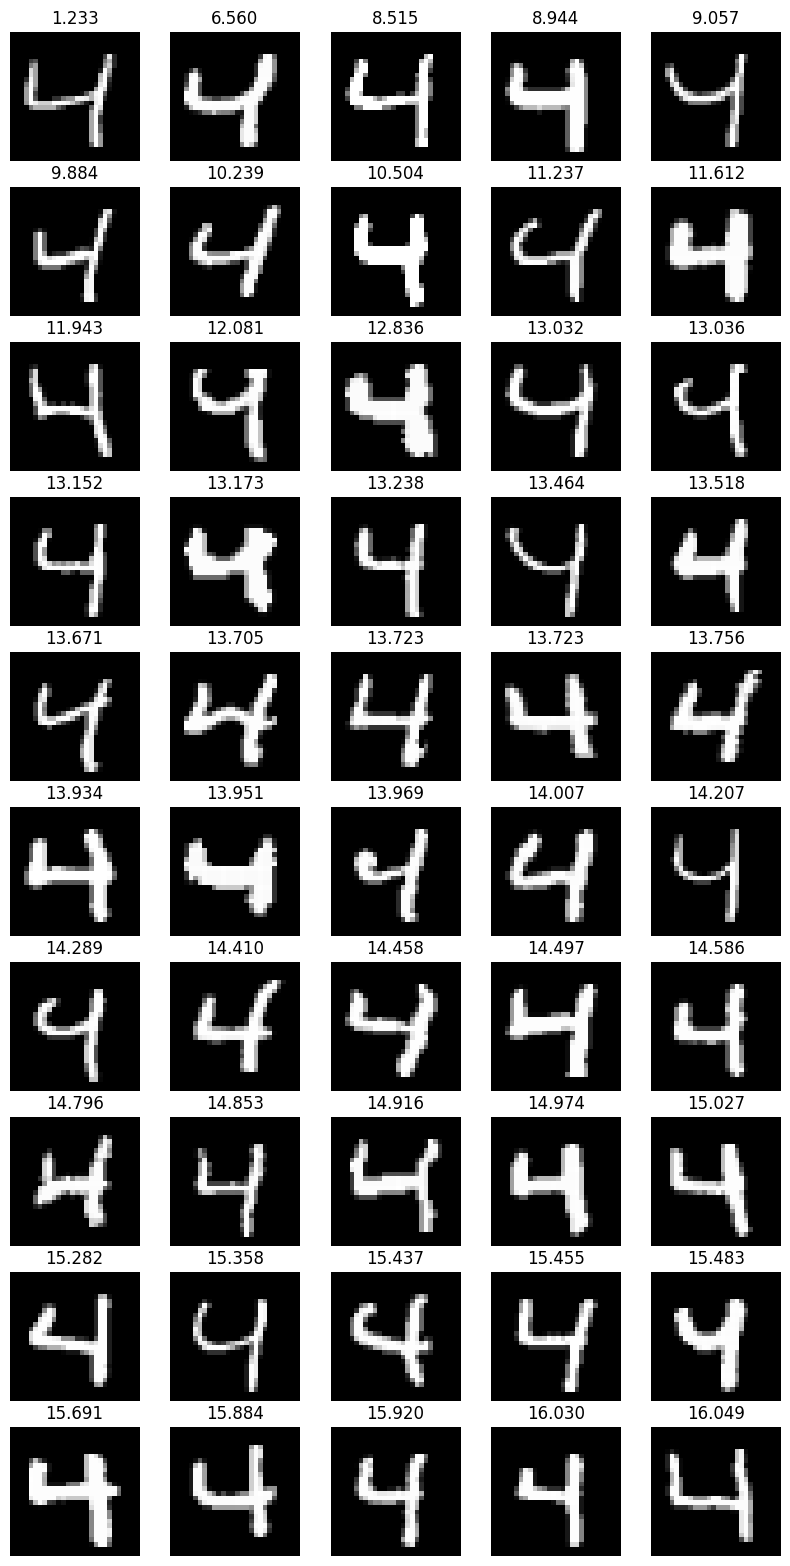

In [29]:
def show_content_retrieval(train_X, top50):

    fig = plt.figure(figsize=(10,50))
    for i in range(len(top50)):
        ax = plt.subplot(25,5,i+1)
        plt.imshow(np.transpose(train_X[top50[i][1]][0], (1,2,0)), cmap='gray')
        plt.title(f'{top50[i][0]:.3f}')
        plt.axis('off')        


image_path = 'contentRetrievalImages/4.jpg'

img = Image.open(image_path).convert('L').resize((28,28))
img_tensor = transform(img).to(device).view(1,1,28,28)

#predict
dataLatent = AE.encoder(img_tensor).cpu().detach().numpy().squeeze()

# compute mse error in latent space between image and elements from training set
results = []
for i in range(len(data['indexes'])) :    
    err = np.sum((dataLatent - data['features'][i].cpu().detach().numpy())**2)
    err /= float(dataLatent.shape[0])
    results.append([err, i])

# sort images by error    
top50 = sorted(results)[:50]

show_content_retrieval(train_set, top50) 

## Denoiser

![denoiser](notebook_images/autoencoder_denoiser.jpg)

### Create noisy train and test data

In [30]:

class CustomDataLoader(torch.utils.data.Dataset):

    def __init__(self, path, transform = None):
        super().__init__()
        
        self.path = path

        self.transform = transform
        self.classes = [x.name for x in os.scandir(path) if x.is_dir()]
        self.classes_to_idx = {cls_name:i for i, cls_name in enumerate(self.classes)}
        self.paths = list(pathlib.Path(path,).glob('*/*.jpg'))
        self.data = []
        self.labels = []
        for p in self.paths:
            with open(p, 'rb') as f:
            
                img = Image.open(f)
                class_name  = p.parent.name
                salt_img = skimage.util.random_noise(np.array(img), mode='salt', amount=0.05)
                salt_img = np.array(255*salt_img, dtype = 'uint8')
                self.data.append([img.convert("L"), salt_img, self.classes_to_idx[class_name]])

    def __len__(self):

        return len(self.paths)    

    def __getitem__(self, idx):

        dat = self.data[idx]
        return self.transform(dat[0]), self.transform(dat[1]), dat[2] 


In [31]:

train_set_noisy = CustomDataLoader('h:/vcpi/mnist/train', transform)
train_loader_noisy = torch.utils.data.DataLoader(train_set_noisy, batch_size=512,
                                          shuffle=True)

test_set_noisy = CustomDataLoader('h:/vcpi/mnist/test', transform)
test_loader_noisy = torch.utils.data.DataLoader(test_set_noisy, batch_size=BATCH_SIZE)


### Show images from the noisy training set

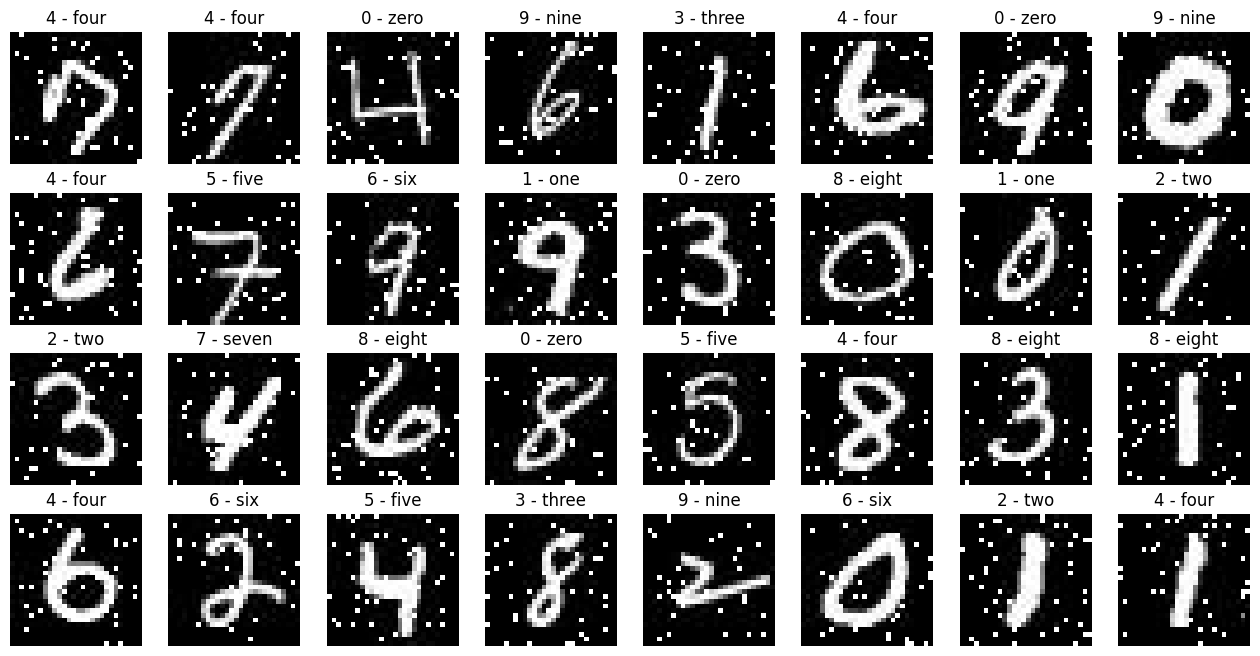

<Figure size 640x480 with 0 Axes>

In [32]:

clean, noisy,_ = next(iter(train_loader_noisy))

vcpi_util.show_images(4,8, noisy, targets, full_dataset.classes) 

### Train the autoencoder with the noisy data

In [33]:
def train_denoiser(model, data_loader, optimizer, loss_fn, epochs):

    model.train()

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0

        for i, (clean, noisy, _) in enumerate(data_loader,0):
            
            
            clean = clean.to(device)
            noisy = noisy.to(device)
            outputs = model(noisy)
            loss = loss_fn(outputs, clean)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss

            

        print(f'Epoch: {epoch:03d};Loss: {running_loss.cpu().detach().numpy()}')
       
    print('Finished Training')


In [36]:
LATENT_SPACE_DIM = 16

AE = AutoEncoder(LATENT_SPACE_DIM)
AE.to(device)  

opt = torch.optim.Adam(AE.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor = 0.1, patience=3)
early_stop = Early_Stopping(9)
loss_fn = torch.nn.loss_fn = torch.nn.MSELoss()

history=train(AE, train_loader, val_loader, 100, loss_fn, opt,  scheduler, early_stop, f'{MODEL_PATH}/autoencoder_denoiser_{LATENT_SPACE_DIM}' )

1500it [00:10, 140.51it/s]


Epoch: 000; Loss: 0.000739; Val Loss: 0.000434; Elapsed time: 12.2557


1500it [00:10, 146.18it/s]


Epoch: 001; Loss: 0.000394; Val Loss: 0.000368; Elapsed time: 11.7978


1500it [00:10, 141.16it/s]


Epoch: 002; Loss: 0.000350; Val Loss: 0.000339; Elapsed time: 12.2491


1500it [00:10, 142.25it/s]


Epoch: 003; Loss: 0.000325; Val Loss: 0.000322; Elapsed time: 12.0926


1500it [00:10, 144.09it/s]


Epoch: 004; Loss: 0.000310; Val Loss: 0.000313; Elapsed time: 11.9492


1500it [00:10, 147.68it/s]


Epoch: 005; Loss: 0.000299; Val Loss: 0.000302; Elapsed time: 11.7915


1500it [00:10, 149.78it/s]


Epoch: 006; Loss: 0.000291; Val Loss: 0.000297; Elapsed time: 11.6825


1500it [00:10, 144.68it/s]


Epoch: 007; Loss: 0.000284; Val Loss: 0.000291; Elapsed time: 11.9901


1500it [00:10, 139.52it/s]


Epoch: 008; Loss: 0.000278; Val Loss: 0.000286; Elapsed time: 12.3866


1500it [00:10, 147.88it/s]


Epoch: 009; Loss: 0.000274; Val Loss: 0.000283; Elapsed time: 11.6906


1500it [00:10, 149.36it/s]


Epoch: 010; Loss: 0.000270; Val Loss: 0.000278; Elapsed time: 11.8018


1500it [00:11, 136.19it/s]


Epoch: 011; Loss: 0.000267; Val Loss: 0.000279; Elapsed time: 12.5348


1500it [00:10, 147.00it/s]


Epoch: 012; Loss: 0.000264; Val Loss: 0.000275; Elapsed time: 11.8069


1500it [00:10, 144.50it/s]


Epoch: 013; Loss: 0.000261; Val Loss: 0.000273; Elapsed time: 11.9555


1500it [00:10, 144.97it/s]


Epoch: 014; Loss: 0.000259; Val Loss: 0.000270; Elapsed time: 11.9340


1500it [00:10, 146.35it/s]


Epoch: 015; Loss: 0.000257; Val Loss: 0.000269; Elapsed time: 11.8755


1500it [00:10, 141.14it/s]


Epoch: 016; Loss: 0.000255; Val Loss: 0.000268; Elapsed time: 12.1601


1500it [00:10, 149.68it/s]


Epoch: 017; Loss: 0.000253; Val Loss: 0.000265; Elapsed time: 11.5541


1500it [00:09, 151.00it/s]


Epoch: 018; Loss: 0.000251; Val Loss: 0.000266; Elapsed time: 11.4844


1500it [00:10, 146.84it/s]


Epoch: 019; Loss: 0.000250; Val Loss: 0.000264; Elapsed time: 11.8026


1500it [00:10, 147.19it/s]


Epoch: 020; Loss: 0.000248; Val Loss: 0.000263; Elapsed time: 11.7052


1500it [00:10, 145.45it/s]


Epoch: 021; Loss: 0.000247; Val Loss: 0.000261; Elapsed time: 12.0531


1500it [00:10, 141.09it/s]


Epoch: 022; Loss: 0.000246; Val Loss: 0.000261; Elapsed time: 12.2057


1500it [00:10, 147.11it/s]


Epoch: 023; Loss: 0.000245; Val Loss: 0.000260; Elapsed time: 11.7509


1500it [00:10, 141.82it/s]


Epoch: 024; Loss: 0.000244; Val Loss: 0.000259; Elapsed time: 12.2673


1500it [00:10, 147.99it/s]


Epoch: 025; Loss: 0.000243; Val Loss: 0.000258; Elapsed time: 11.6624


1500it [00:10, 147.27it/s]


Epoch: 026; Loss: 0.000242; Val Loss: 0.000256; Elapsed time: 11.7065


1500it [00:10, 148.33it/s]


Epoch: 027; Loss: 0.000241; Val Loss: 0.000256; Elapsed time: 11.6577
Early stopping!
Finished Training


In [37]:
reload = torch.load(f'autoencoder_models/autoencoder_denoiser_{LATENT_SPACE_DIM}_best.pt')
print(reload['epoch'])
AE = AutoEncoder(LATENT_SPACE_DIM)
AE.to(device)
AE.load_state_dict(reload['model'])

27


<All keys matched successfully>

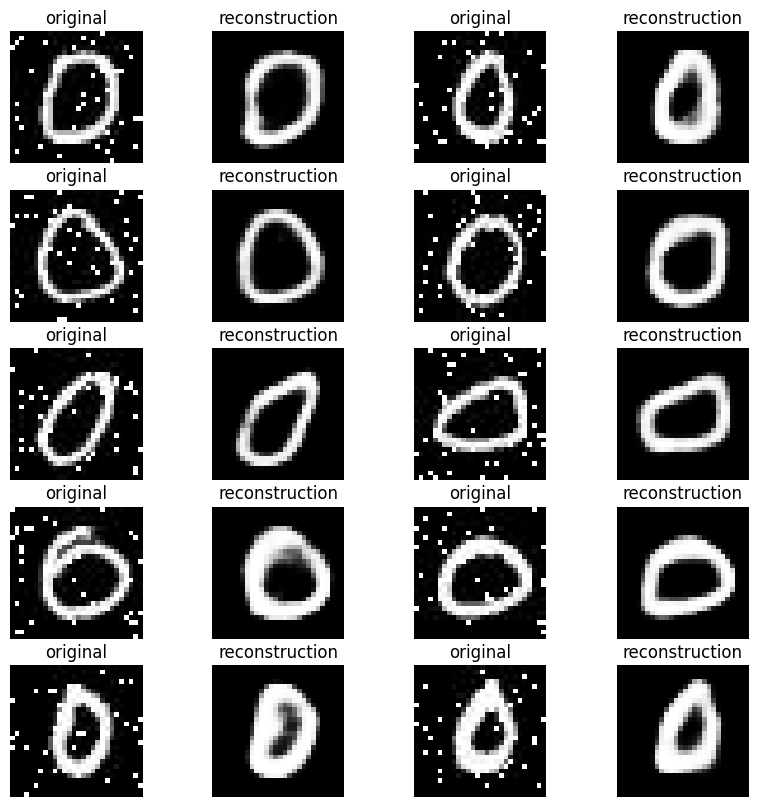

In [38]:
i, noisy, _ = next(iter(test_loader_noisy))
recon = AE(noisy.to(device))
    
show_preds(noisy, recon, 10)